In [35]:
# help function
from transfer_learning import NeuralNet
from dataset_loader import data_loader, get_descriptors, one_filter, data_scaler

# modules
import torch
import torch.nn as nn
import torch.optim as optim

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

# New
from transfer_learning import MyDataset
from Statistics_helper import stratified_cluster_sample
from ignite.engine import Engine, Events, create_supervised_evaluator
from ignite.metrics import Loss
from ignite.contrib.metrics.regression import R2Score
import time
from ignite.engine import Events, create_supervised_evaluator

# file name and data path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_path = os.getcwd()
file_name = "data/CrystGrowthDesign_SI.csv"

"""
Data description.

    Descriptors:
        'void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest'
    Source task:
        'H2@100 bar/243K (wt%)'
    Target tasks:
        'H2@100 bar/130K (wt%)' 'CH4@100 bar/298 K (mg/g)' '5 bar Xe mol/kg' '5 bar Kr mol/kg'
"""

descriptor_columns = [
    "void fraction",
    "Vol. S.A.",
    "Grav. S.A.",
    "Pore diameter Limiting",
    "Pore diameter Largest",
]
one_filter_columns = ["H2@100 bar/243K (wt%)"]
another_filter_columns = ["H2@100 bar/130K (wt%)"]

# load data
data = data_loader(base_path, file_name)
data = data.reset_index(drop=True)
# extract descriptors and gas adsorptions
one_property = one_filter(data, one_filter_columns)
descriptors = get_descriptors(data, descriptor_columns)

# parameters
input_size = 6
hidden_size_1 = 128
hidden_size_2 = 64
output_size = 1
learning_rate = 0.0002

# file specifics 
epochs = 100
batch_size = 10000
filename = f"data_epochs-{epochs}_bs-{batch_size}"

#format data
df, t_1, t_2, y_1, y_2 = stratified_cluster_sample(
    1, data, descriptor_columns, one_filter_columns[0], 5, net_out=True
)
df = df[0]
# df=df.drop("Cluster",axis=1)
interest = one_filter_columns[0]
descriptor_columns.append("Cluster")
features = descriptor_columns

df_train, df_val, y_df_train, y_df_val = train_test_split(
    df[features], df[interest], test_size=0.1
)
df_train[interest] = np.array(y_df_train)
df_val[interest] = np.array(y_df_val)
first = MyDataset(df_train, interest, features)
train_loader = torch.utils.data.DataLoader(first, batch_size=512)
second = MyDataset(df_val, interest, features)
val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

train_loss = []
train_r_2 = []
val_loss = []
val_r_2 = []
net_time = []
#create model
model = NeuralNet(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train_step(engine, batch):
    x, y = batch
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    return loss.item()

trainer = Engine(train_step)
# trainer.logger = setup_logger("Trainer")
@trainer.on(Events.EPOCH_COMPLETED(every=10))
def log_training(engine):
    batch_loss = engine.state.output
    lr = optimizer.param_groups[0]["lr"]
    e = engine.state.epoch
    n = engine.state.max_epochs
    i = engine.state.iteration
    print(f"Epoch {e}/{n} : {i} - batch loss: {batch_loss}, lr: {lr}")


metrics = {"loss": Loss(criterion), "r_2": R2Score()}

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
# train_evaluator.logger = setup_logger("Train Evaluator")
validation_evaluator = create_supervised_evaluator(
    model, metrics=metrics, device=device
)
# validation_evaluator.logger = setup_logger("Val Evaluator")


@trainer.on(Events.EPOCH_COMPLETED)
def store_metrics(engine):
    train_evaluator.run(train_loader)
    validation_evaluator.run(val_loader)
    out = train_evaluator.state.metrics
    out_2 = validation_evaluator.state.metrics
    end = time.time()
    train_loss.append(out["loss"])
    train_r_2.append(out["r_2"])
    val_loss.append(out_2["loss"])
    val_r_2.append(out_2["r_2"])
    net_time.append(end-start)


train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size,shuffle=True)
start = time.time()
trainer.run(train_loader, max_epochs=epochs)

dic = {
    "train_loss": train_loss,
    "train_r_2": train_r_2,
    "val_loss": val_loss,
    "val_r_2": val_r_2,
    "net_time" : net_time,
}
case_metrics = pd.DataFrame.from_dict(dic)
case_metrics.to_json(f"{filename}.json")

c:\Users\gcooper2\Documents\GitHub\TL_MOF\Statistics_helper.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
c:\Users\gcooper2\Documents\GitHub\TL_MOF\Statistics_helper.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
c:\Users\gcooper2\Documents\GitHub\TL_MOF\Statistics_helper.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train=X_train.append(X_train_1)
c:\Users\gcooper2\Documents\GitHub\TL_MOF\Statistics_helper.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test=X_test.append(X_test_1)
c:\Users\gcooper2\Documents\GitHub\TL_MOF\Statistics_helpe

Epoch 10/100 : 20 - batch loss: 34.16642761230469, lr: 0.0002
Epoch 20/100 : 40 - batch loss: 30.39147186279297, lr: 0.0002
Epoch 30/100 : 60 - batch loss: 26.154664993286133, lr: 0.0002
Epoch 40/100 : 80 - batch loss: 21.85138511657715, lr: 0.0002
Epoch 50/100 : 100 - batch loss: 17.82154083251953, lr: 0.0002
Epoch 60/100 : 120 - batch loss: 14.253239631652832, lr: 0.0002
Epoch 70/100 : 140 - batch loss: 11.207965850830078, lr: 0.0002
Epoch 80/100 : 160 - batch loss: 8.695453643798828, lr: 0.0002
Epoch 90/100 : 180 - batch loss: 6.66444730758667, lr: 0.0002
Epoch 100/100 : 200 - batch loss: 5.070093154907227, lr: 0.0002


In [33]:
g=pd.read_json("1.json")

<AxesSubplot:>

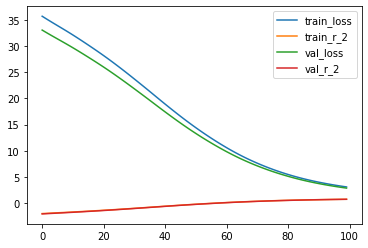

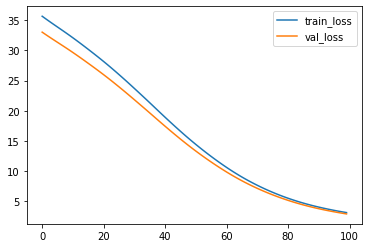

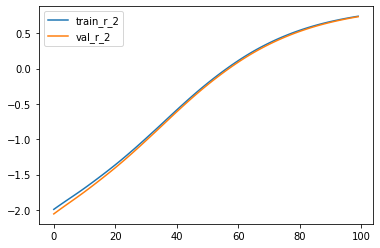

In [31]:
g[['train_loss', 'train_r_2', 'val_loss', 'val_r_2']][:100].plot()
g[['train_loss', 'val_loss' ]][:].plot()
g[['train_r_2', 'val_r_2' ]][:].plot()

NameError: name 'plt' is not defined

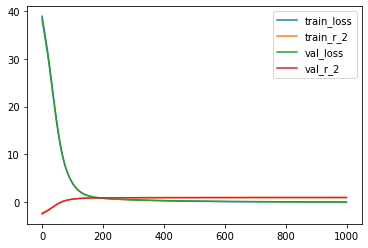

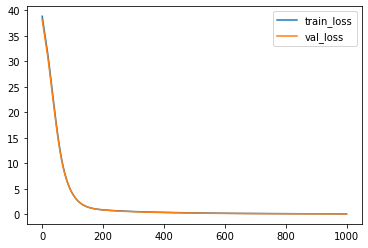

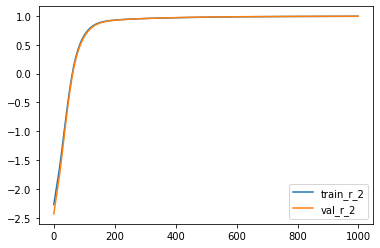

In [34]:
g[['train_loss', 'train_r_2', 'val_loss', 'val_r_2']].plot()
g[['train_loss', 'val_loss' ]][:].plot()
g[['train_r_2', 'val_r_2' ]][:].plot()